In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from jupyter_dash import JupyterDash
from dash import dcc, html, State
from dash.dependencies import Input, Output
import plotly.express as px  

from dash import dash_table

app = JupyterDash(__name__)

In [2]:
df = pd.read_csv('../Sentiment & Engagement Datasets/ready_data_score.csv')

In [3]:
df.head(2)

,id,text,title,author,num_comments,post_id,upvote_ratio,score,url,subreddit,link_flair_text,link_flair_template_id,created_datetime,day_of_week,hour_of_day,month,year,sentiment_score
0,41034.0,Hi context year old guy Amsterdam currently em...,Lazy job or Hard job?,Weak_Assumption_6889,8,1bfpxll,0.33,0,https://www.reddit.com/r/careeradvice/comments...,careeradvice,Unknown,Unknown,2024-03-15 22:07:22,Friday,22.0,March,2024,0.7579
1,43519.0,Looking new role havenut much traction Recentl...,Roast my Resume Pls,Neither_Trash,1,1bh8md2,0.99,1,https://i.redd.it/n918fjprlyoc1.jpeg,resumes,Review my resume • I'm in North America,c292b8e0-28b9-11ec-874c-325b17e851a3,2024-03-17 21:05:40,Sunday,21.0,March,2024,0.6369


Goal: to understand how different communities or topics drive user interaction. 

we'll focus on the following features: subreddit, link_flair_text (flairs), and engagement metrics (num_comments, score, upvote_ratio).

### Getting Data Ready

In [6]:
### check the engagement metrics first

engagement_summary = df[['num_comments', 'score', 'upvote_ratio']].describe()
print(engagement_summary)

       num_comments         score  upvote_ratio
count   7862.000000   7862.000000   7862.000000
mean      68.064360    324.232384      0.800085
std      280.069188   1660.464623      0.227312
min        0.000000      0.000000      0.050000
25%        1.000000      1.000000      0.670000
50%        4.000000      1.000000      0.900000
75%       16.000000      8.000000      1.000000
max     8325.000000  43206.000000      1.000000


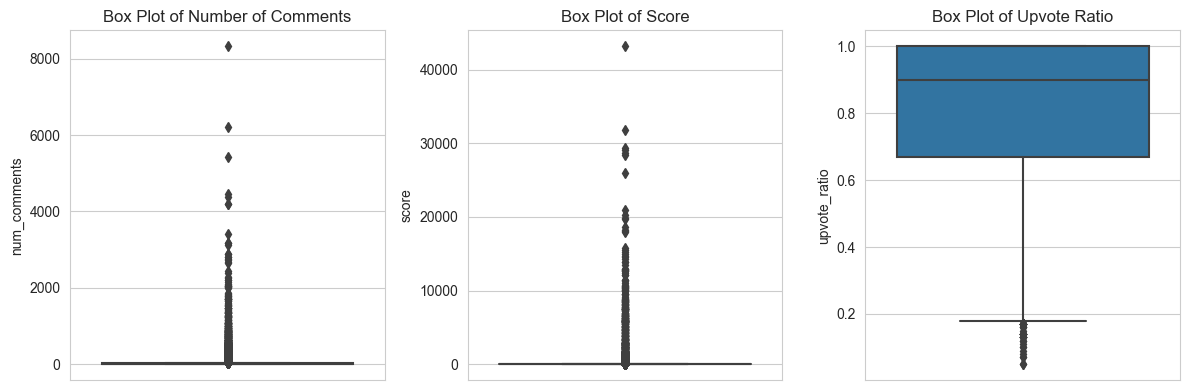

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.boxplot(y=df['num_comments'])
plt.title('Box Plot of Number of Comments')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['score'])
plt.title('Box Plot of Score')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['upvote_ratio'])
plt.title('Box Plot of Upvote Ratio')

plt.tight_layout()
plt.show()



In [11]:
# Applying log transformation with an offset to avoid log(0)
df['log_num_comments'] = np.log1p(df['num_comments'])  # log(x + 1)
df['log_score'] = np.log1p(df['score'])


In [12]:
# Defining a function to detect outliers
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = ((series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR)))
    return outlier_mask

# Apply the function to detect outliers for 'num_comments' and 'score'
df['outlier_num_comments'] = detect_outliers(df['num_comments'])
df['outlier_score'] = detect_outliers(df['score'])


In [14]:
## check subreddit. 
unique_subreddits = df['subreddit'].unique()
print(unique_subreddits)  # This will display all unique subreddit names


['careeradvice' 'resumes' 'ITCareerQuestions' 'FinancialCareers'
 'LegalAdviceOffTopic' 'teachers' 'AskHR' 'sales' 'careerguidance' 'jobs'
 'cscareerquestions' 'EngineeringCareers']


In [15]:
subreddit_counts = df['subreddit'].value_counts()
print(subreddit_counts)


subreddit
careeradvice           983
teachers               905
LegalAdviceOffTopic    903
ITCareerQuestions      867
FinancialCareers       776
careerguidance         691
jobs                   640
cscareerquestions      542
resumes                523
sales                  501
AskHR                  451
EngineeringCareers      80
Name: count, dtype: int64


In [16]:
# Filter out the 'EngineeringCareers' subreddit
df = df[df['subreddit'] != 'EngineeringCareers']


In [20]:
##check the link_flair_text

# Group the flairs by subreddit and list unique flairs in each
flairs_by_subreddit = df.groupby('subreddit')['link_flair_text'].unique()


subreddit
AskHR                  [Unknown, Policy & Procedures, Career Developm...
FinancialCareers       [Unknown, Breaking In, Profession Insights, An...
ITCareerQuestions      [Unknown, Seeking Advice, Early Career, Mid Ca...
LegalAdviceOffTopic                       [Unknown, BestOf, Update, nan]
careeradvice                                              [Unknown, nan]
careerguidance         [Unknown, Advice, Education & Qualifications, ...
cscareerquestions      [Unknown, New Grad, Experienced, Student, Meta...
jobs                   [Applications, Weekly Megathread, Discipline, ...
resumes                [Review my resume • I'm in North America, Revi...
sales                  [Sales Topic General Discussion, Sales Careers...
teachers               [Teacher Support &/or Advice, Student Teacher ...
Name: link_flair_text, dtype: object

In [21]:
for subreddit, flairs in flairs_by_subreddit.items():
    print(f"Subreddit: {subreddit}")
    print(f"Unique Flairs: {flairs}\n")


Subreddit: AskHR
Unique Flairs: ['Unknown' 'Policy & Procedures' 'Career Development' 'Workplace Issues'
 'Off Topic / Other' 'Employment Law' 'Compensation & Payroll'
 'Recruitment & Talent Acquisition' 'Employee Relations' 'Leaves'
 'California' 'Resignation/Termination' 'Performance Management'
 'Learning & Development' 'United States Specific' 'Benefits'
 'Unemployment' 'Canada' 'UK' 'Training' 'Risk Management'
 'Diversity & Inclusion' nan 'Recruitment' 'ANSWERED/RESOLVED']

Subreddit: FinancialCareers
Unique Flairs: ['Unknown' 'Breaking In' 'Profession Insights' 'Announcement'
 'Education & Certifications' 'Career Progression' 'Interview Advice'
 'Off Topic / Other' 'Tools and Resources' 'Networking' 'Resume Feedback'
 'Ask Me Anything' 'Skill Development' nan]

Subreddit: ITCareerQuestions
Unique Flairs: ['Unknown' 'Seeking Advice' 'Early Career' 'Mid Career' nan]

Subreddit: LegalAdviceOffTopic
Unique Flairs: ['Unknown' 'BestOf' 'Update' nan]

Subreddit: careeradvice
Unique Fla

In [22]:
df.to_csv('../Sentiment & Engagement Datasets/subreddit_data.csv')

In [23]:
# Exclude posts with "Unknown" flair
df_filtered = df[df['link_flair_text'] != 'Unknown']

# Optionally, also exclude posts where flair information is missing (NaN)
df_filtered = df_filtered.dropna(subset=['link_flair_text'])


In [24]:
# Group the flairs by subreddit and list unique flairs in each
flairs_by_subreddit = df_filtered.groupby('subreddit')['link_flair_text'].unique()

In [25]:
for subreddit, flairs in flairs_by_subreddit.items():
    print(f"Subreddit: {subreddit}")
    print(f"Unique Flairs: {flairs}\n")

Subreddit: AskHR
Unique Flairs: ['Policy & Procedures' 'Career Development' 'Workplace Issues'
 'Off Topic / Other' 'Employment Law' 'Compensation & Payroll'
 'Recruitment & Talent Acquisition' 'Employee Relations' 'Leaves'
 'California' 'Resignation/Termination' 'Performance Management'
 'Learning & Development' 'United States Specific' 'Benefits'
 'Unemployment' 'Canada' 'UK' 'Training' 'Risk Management'
 'Diversity & Inclusion' 'Recruitment' 'ANSWERED/RESOLVED']

Subreddit: FinancialCareers
Unique Flairs: ['Breaking In' 'Profession Insights' 'Announcement'
 'Education & Certifications' 'Career Progression' 'Interview Advice'
 'Off Topic / Other' 'Tools and Resources' 'Networking' 'Resume Feedback'
 'Ask Me Anything' 'Skill Development']

Subreddit: ITCareerQuestions
Unique Flairs: ['Seeking Advice' 'Early Career' 'Mid Career']

Subreddit: LegalAdviceOffTopic
Unique Flairs: ['BestOf' 'Update']

Subreddit: careerguidance
Unique Flairs: ['Advice' 'Education & Qualifications' 'Europe' '

In [26]:
# Define a mapping from original flairs to broader categories
flair_mapping = {
    'Employment Law': 'Legal and Compliance', 'Leaves': 'Legal and Compliance', 
    'California': 'Legal and Compliance', 'Resignation/Termination': 'Legal and Compliance', 
    'United States Specific': 'Legal and Compliance', 'Canada': 'Legal and Compliance', 
    'UK': 'Legal and Compliance', 'Recruitment & Talent Acquisition': 'Recruitment and Talent',
    'Recruitment': 'Recruitment and Talent', 'Compensation & Payroll': 'Compensation and Benefits',
    'Benefits': 'Compensation and Benefits', 'Unemployment': 'Compensation and Benefits',
    'Career Development': 'Career and Development', 'Learning & Development': 'Career and Development',
    'Training': 'Career and Development', 'Diversity & Inclusion': 'Career and Development',
    'Workplace Issues': 'Workplace Issues', 'Employee Relations': 'Workplace Issues',
    'Performance Management': 'Workplace Issues', 'Risk Management': 'Workplace Issues',
    'Policy & Procedures': 'General HR', 'ANSWERED/RESOLVED': 'General HR', 
    'Off Topic / Other': 'General HR'
}

# Apply the mapping to the DataFrame
df_filtered['flair_category'] = df_filtered['link_flair_text'].map(flair_mapping)
